<a href="https://colab.research.google.com/github/Czedros/CSE352-Machine-Learning-Assignments/blob/main/CSE352MidtermMakeupAssignmentEmpty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Name: [Enter Here]

I understand that my submission needs to be my own work: [Initials]

I understand that ChatGPT / Copilot / other AI tools are not allowed:  [Initials]

Total Points: **75**

Complete this notebook and submit it (save/print as pdf). Make sure all output is correct in the pdf before submitting (it sometimes gets cut off).

 The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Overview

In this assignment, you will:
- Implement the rules and structure for Ultimate Tic-Tac-Toe
- Design a basic Monte Carlo Tree Search (MCTS) agent
- Use MCTS to play against a human in the command line

#Setup

To start this assignemnt, We first install a few neccesary Packages.

In [ ]:
!pip install numpy

#Ultimate Tic-Tac-Toe

Ultimate Tic-Tac-Toe is a strategic extension of the classic Tic-Tac-Toe game. Rather than a single 3×3 grid, Ultimate Tic-Tac-Toe consists of a 3×3 grid where each cell contains another 3×3 Tic-Tac-Toe board. This layered setup creates a more complex game structure requiring players to think multiple moves ahead.

The game was first popularized online in the early 2010s and is designed to emphasize positional play, long-term strategy, and adaptation to an evolving board state. Each player, X or O, takes turns placing their mark in a cell of one of the smaller boards. However, the twist lies in the move constraints: a player’s move determines which of the nine small boards their opponent must play in next. Specifically, if a player places their mark in cell (i, j) of a small board, their opponent must play in the (i, j) small board on their next turn.

The objective is to win the larger game by winning three small boards in a row—horizontally, vertically, or diagonally—similar to classic Tic-Tac-Toe. A small board is won when a player has three marks in a row within it. If a player is sent to a board that is already won or drawn, they may play in any open board of their choosing.

Ultimate Tic-Tac-Toe presents a more intricate challenge than its predecessor and is a rich environment for studying game trees, simulation-based planning, and reinforcement learning. For more information about the game and strategic insights, refer to its [Wikipedia page](https://en.wikipedia.org/wiki/Ultimate_tic-tac-toe).

#Visualizer Helper

There are 2 ways to go about creating a board for Ultimate Tic Tac Toe, a 9x9 grid or a 3x3 of 3x3 grids. These will result in different ways to visualize the board.


The following is a universal

In [72]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def draw_ultimate_board(board, highlight=None):
    """
    Pure Visualizer: Draws a 9x9 board.

    board: 9x9 numpy array (0: empty, 1: X, 2: O)
    highlight: (row, col) of active small board.
    """
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(0, 9)
    ax.set_ylim(0, 9)

    # Draw grid
    for i in range(10):
        lw = 2 if i % 3 == 0 else 0.5
        ax.axhline(i, color='black', lw=lw)
        ax.axvline(i, color='black', lw=lw)

    # Draw pieces
    for row in range(9):
        for col in range(9):
            val = board[row, col]
            if val == 1:
                ax.text(col+0.5, 8.5-row, 'X', ha='center', va='center', fontsize=16)
            elif val == 2:
                ax.text(col+0.5, 8.5-row, 'O', ha='center', va='center', fontsize=16)

    # Highlight active board
    if highlight:
        y, x = highlight
        rect = patches.Rectangle((x*3, 9-(y+1)*3), 3, 3, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

    plt.show()



An usage of the visualizer code.

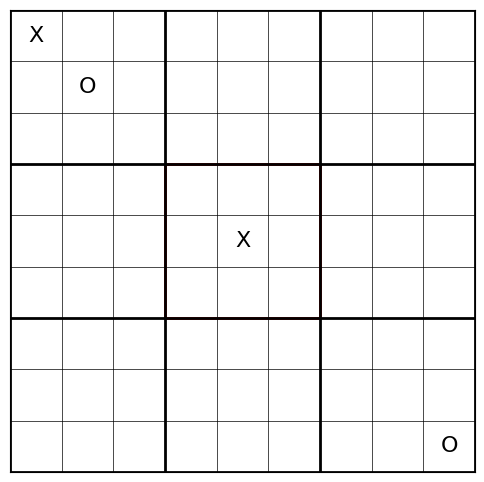

In [73]:
# Example board
board = np.zeros((9, 9), dtype=int)
board[0, 0] = 1
board[1, 1] = 2
board[4, 4] = 1
board[8, 8] = 2

draw_ultimate_board(board, highlight=(1, 1))

In [74]:
def nested_list_to_board(nested_game, highlight=None):
    """
    Converts a 3x3 list of 3x3 arrays to a 9x9 board and draws it.
    """
    board_array = np.zeros((9, 9), dtype=int)
    for br in range(3):
        for bc in range(3):
            sb = nested_game[br][bc]
            if isinstance(sb, np.ndarray):
                board_array[br*3:(br+1)*3, bc*3:(bc+1)*3] = sb
            else:
                board_array[br*3:(br+1)*3, bc*3:(bc+1)*3] = np.array(sb)

    draw_ultimate_board(board_array, highlight=highlight)


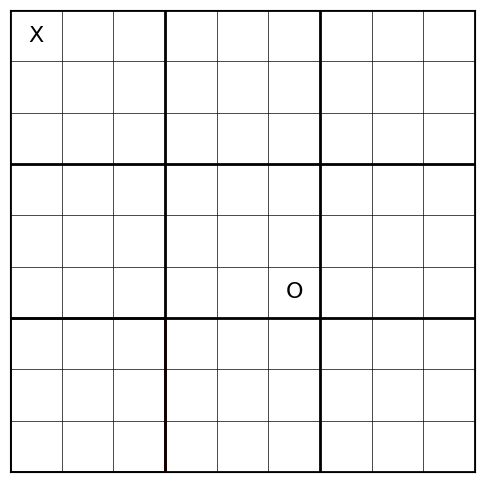

In [75]:
nested_game = [
    [np.zeros((3,3), dtype=int) for _ in range(3)] for _ in range(3)
]
nested_game[0][0][0,0] = 1
nested_game[1][1][2,2] = 2

nested_list_to_board(nested_game, highlight=(2, 0))

#Part 1: Ultimate Tic-Tac-Toe [X Points]
In the first part, you will implement the mechanics of Ultimate Tic-Tac-Toe, defining how the game progresses and determining legal moves and win conditions.

This includes
-

In [76]:
import numpy as np

class SmallBoard:
    def __init__(self):
        self.grid = np.zeros((3, 3), dtype=int)  # 0 = empty, 1 = X, 2 = O
        self.winner = 0  # 0 = no one, 1 = X, 2 = O, -1 = tie
        self.active = True

    def play_move(self, row, col, player):
        if self.grid[row, col] != 0 or not self.active:
            return False
        self.grid[row, col] = player
        self.check_winner()
        return True

    def check_winner(self):
        for i in range(3):
            if np.all(self.grid[i, :] == self.grid[i, 0]) and self.grid[i, 0] != 0:
                self._declare_winner(self.grid[i, 0])
                return
            if np.all(self.grid[:, i] == self.grid[0, i]) and self.grid[0, i] != 0:
                self._declare_winner(self.grid[0, i])
                return
        if np.all(np.diag(self.grid) == self.grid[0, 0]) and self.grid[0, 0] != 0:
            self._declare_winner(self.grid[0, 0])
            return
        if np.all(np.diag(np.fliplr(self.grid)) == self.grid[0, 2]) and self.grid[0, 2] != 0:
            self._declare_winner(self.grid[0, 2])
            return
        if np.all(self.grid != 0):
            self._declare_winner(-1)

    def _declare_winner(self, winner):
        self.winner = winner
        self.active = False


In [77]:
import numpy as np
import random

class UltimateBoard:
    def __init__(self):
        self.boards = [[SmallBoard() for _ in range(3)] for _ in range(3)]
        self.current_player = 1  # 1 = X, 2 = O
        self.next_board = None  # (row, col) of next board; None means any active board
        self.global_winner = 0

    def play_move(self, big_r, big_c, small_r, small_c):
        board = self.boards[big_r][big_c]
        if self.next_board and (big_r, big_c) != self.next_board:
            print("You must play in board", self.next_board)
            return False
        if not board.play_move(small_r, small_c, self.current_player):
            print("Invalid move.")
            return False

        # Update next board
        next_r, next_c = small_r, small_c
        if self.boards[next_r][next_c].active:
            self.next_board = (next_r, next_c)
        else:
            self.next_board = None  # Any active board

        # Check for global win
        self.check_global_winner()

        # Swap player
        self.current_player = 3 - self.current_player
        return True

    def check_global_winner(self):
        grid = np.array([[b.winner if b.winner > 0 else 0 for b in row] for row in self.boards])
        for i in range(3):
            if np.all(grid[i, :] == grid[i, 0]) and grid[i, 0] != 0:
                self.global_winner = grid[i, 0]
                return
            if np.all(grid[:, i] == grid[0, i]) and grid[0, i] != 0:
                self.global_winner = grid[0, i]
                return
        if np.all(np.diag(grid) == grid[0, 0]) and grid[0, 0] != 0:
            self.global_winner = grid[0, 0]
            return
        if np.all(np.diag(np.fliplr(grid)) == grid[0, 2]) and grid[0, 2] != 0:
            self.global_winner = grid[0, 2]
            return

    def get_legal_moves(self):
        moves = []
        for big_r in range(3):
            for big_c in range(3):
                board = self.boards[big_r][big_c]
                if self.next_board and (big_r, big_c) != self.next_board:
                    continue
                if board.active:
                    for i in range(3):
                        for j in range(3):
                            if board.grid[i, j] == 0:
                                moves.append((big_r, big_c, i, j))
        return moves

    def display(self):
        # Display the full board in CLI format
        def cell_symbol(val):
            return '.' if val == 0 else ('X' if val == 1 else 'O')

        for big_r in range(3):
            for r in range(3):
                line = ''
                for big_c in range(3):
                    board = self.boards[big_r][big_c]
                    line += ' '.join(cell_symbol(board.grid[r, c]) for c in range(3)) + ' | '
                print(line)
            print('-' * 20)


In [78]:
def ultimate_board_to_board(game, highlight=None):
    """
    Converts an UltimateBoard object into a 9x9 board and draws it.
    """
    board_array = np.zeros((9, 9), dtype=int)
    for br in range(3):
        for bc in range(3):
            sb = game.boards[br][bc].grid
            board_array[br*3:(br+1)*3, bc*3:(bc+1)*3] = sb

    # If highlight not given, automatically use game's next_board if available
    if highlight is None and hasattr(game, 'next_board'):
        highlight = game.next_board

    draw_ultimate_board(board_array, highlight=highlight)



In [79]:
def random_bot(board: UltimateBoard):
    return random.choice(board.get_legal_moves())

def play_game(agent_X=None, agent_O=None):
    """
    Play a game of Ultimate Tic-Tac-Toe.

    agent_X: function that takes (UltimateBoard) and returns a move, or None for human
    agent_O: function that takes (UltimateBoard) and returns a move, or None for human
    """
    game = UltimateBoard()

    while not game.global_winner and game.get_legal_moves():
        print("\nCurrent Turn: Player {}".format("X" if game.current_player == 1 else "O"))
        ultimate_board_to_board(game)

        if game.next_board:
            print("You must play in small board:", game.next_board)
        else:
            print("You may play in any active board.")

        # Determine agent for this turn
        agent = agent_X if game.current_player == 1 else agent_O

        if agent is None:
            # Human move
            move = input("Enter your move (big_r big_c small_r small_c): ").split()
            try:
                move = tuple(map(int, move))
                if len(move) != 4 or not game.play_move(*move):
                    print("Try again.")
            except:
                print("Invalid input.")
        else:
            # Bot move
            move = agent(game)
            print(f"Bot plays: {move}")
            game.play_move(*move)

    print("\nFinal Result:")
    ultimate_board_to_board(game)
    if game.global_winner:
        print("Winner: Player", "X" if game.global_winner == 1 else "O")
    else:
        print("Game ended in a draw.")

#Part 2: Monte Carlo Tree Search

The second part of this assignment is creating an agent that uses MCTS that

In [80]:
import copy

def copy_game_state(game):
    return copy.deepcopy(game)

def count_small_boards_won(game, player):
    count = 0
    for br in range(3):
        for bc in range(3):
            board = game.boards[br][bc]
            if not board.active and board.winner == player:
                count += 1
    return count

def smarter_rollout(game_state):
    """
    Smarter rollout that rewards winning small boards during rollout (reward shaping).
    """
    temp_game = copy_game_state(game_state)
    reward = 0.0  # cumulative reward

    while not temp_game.global_winner and temp_game.get_legal_moves():
        moves = temp_game.get_legal_moves()

        # Track small board win count before move
        small_board_wins_before = count_small_boards_won(temp_game, temp_game.current_player)

        # 1. Try to win the whole game immediately
        for move in moves:
            sim = copy_game_state(temp_game)
            sim.play_move(*move)
            if sim.global_winner == temp_game.current_player:
                temp_game.play_move(*move)
                break
        else:
            # 2. Try to win a small board
            for move in moves:
                sim = copy_game_state(temp_game)
                big_r, big_c, _, _ = move
                board = sim.boards[big_r][big_c]
                if not board.active and board.winner == temp_game.current_player:
                    temp_game.play_move(*move)
                    break
            else:
                # 3. Try to block opponent
                opponent = 3 - temp_game.current_player
                for move in moves:
                    sim = copy_game_state(temp_game)
                    big_r, big_c, _, _ = move
                    board = sim.boards[big_r][big_c]
                    if not board.active and board.winner == opponent:
                        temp_game.play_move(*move)
                        break
                else:
                    # 4. Prefer center center
                    center_moves = [m for m in moves if (m[0], m[1], m[2], m[3]) == (1,1,1,1)]
                    if center_moves:
                        move = random.choice(center_moves)
                    else:
                        move = random.choice(moves)
                    temp_game.play_move(*move)

        # After playing move: check how many small boards won now
        small_board_wins_after = count_small_boards_won(temp_game, temp_game.current_player)

        # If we captured a new small board, give a bonus
        bonus_captures = small_board_wins_after - small_board_wins_before
        reward += 0.05 * bonus_captures  # 0.05 bonus per small board win

    # Final reward based on game outcome
    if temp_game.global_winner == 0:
        reward += 0.5  # Draw
    elif temp_game.global_winner == game_state.current_player:
        reward += 1
    else:
        reward += 0

    return reward

In [81]:
import math
import random

class MCTSNode_PUCT:
    def __init__(self, game_state, parent=None, move=None, prior_prob=1.0):
        self.game_state = game_state
        self.parent = parent
        self.move = move
        self.children = []

        self.visits = 0
        self.total_value = 0.0  # Total win value (for Q(s,a))
        self.prior_prob = prior_prob  # P(s,a) given by the policy

        self.untried_moves = game_state.get_legal_moves()
        random.shuffle(self.untried_moves)  # Shuffle once at creation

    def is_fully_expanded(self):
        return len(self.untried_moves) == 0

    def best_child(self, c_puct=1.4):
        """
        Selects the child with the highest PUCT value.
        """
        total_visits = sum(child.visits for child in self.children)
        choices = []
        for child in self.children:
            q_value = child.total_value / child.visits if child.visits > 0 else 0
            u_value = c_puct * child.prior_prob * math.sqrt(total_visits) / (1 + child.visits)
            choices.append(q_value + u_value)

        return self.children[choices.index(max(choices))]

    def expand(self, prior_func):
        """
        Expand one of the untried moves.
        Assign a prior probability using the prior_func.
        """
        move = self.untried_moves.pop()
        new_game_state = copy_game_state(self.game_state)
        new_game_state.play_move(*move)

        # Prior probability assigned here
        prior_prob = prior_func(new_game_state, move)

        child_node = MCTSNode_PUCT(new_game_state, parent=self, move=move, prior_prob=prior_prob)
        self.children.append(child_node)
        return child_node

    def backpropagate(self, result):
        self.visits += 1
        self.total_value += result
        if self.parent:
            self.parent.backpropagate(1 - result)



In [83]:
def mcts_search_puct(root, max_simulations=1000, c_puct=0.8, verbose=True):
    """
    Run MCTS with PUCT selection, for a fixed number of simulations.
    If verbose=True, prints out analysis at the end.
    """
    def simple_prior_func(game_state, move):
        if (move[2], move[3]) == (1,1):
            return 1.5  # Center move boost
        else:
            return 1.0

    for _ in range(max_simulations):
        node = root

        # Selection
        while node.is_fully_expanded() and node.children:
            node = node.best_child(c_puct=c_puct)

        # Expansion
        if node.untried_moves:
            node = node.expand(prior_func=simple_prior_func)

        # Simulation
        result = smarter_rollout(node.game_state)

        # Backpropagation
        node.backpropagate(result)

    # After search: print info
    if verbose:
        print(f"\n[MCTS Summary] Simulations: {max_simulations}")
        children = sorted(root.children, key=lambda c: c.visits, reverse=True)
        for child in children:
            q_value = child.total_value / child.visits if child.visits > 0 else 0
            print(f"Move {child.move} | Visits: {child.visits} | Winrate: {q_value:.2f} | Prior: {child.prior_prob:.2f}")

        best = root.best_child(c_puct=0)
        best_q = best.total_value / best.visits if best.visits > 0 else 0
        print(f">>> Selected Move: {best.move} | Winrate: {best_q:.2f}\n")

    return root.best_child(c_puct=0)




In [82]:
def mcts_puct_bot(game, max_simulations=1000):
    """
    MCTS PUCT agent using a fixed number of simulations.

    Parameters:
    - game: current UltimateBoard
    - max_simulations: number of MCTS rollouts to perform
    """
    root = MCTSNode_PUCT(copy_game_state(game))
    best_child = mcts_search_puct(root, max_simulations=max_simulations)
    return best_child.move



In [90]:
import math
import random
import numpy as np

class EnhancedMCTSNode:
    def __init__(self, game_state, parent=None, move=None):
        self.game_state = game_state
        self.parent = parent
        self.move = move
        self.children = []
        self.visits = 0
        self.total_reward = 0.0
        self.prior = 1.0  # Prior probability for PUCT
        self.untried_moves = self._prioritized_moves(game_state.get_legal_moves())

    def _prioritized_moves(self, moves):
        """Assign priorities to moves based on strategic value"""
        prioritized = []
        for move in moves:
            # Heuristic: Prefer center and corners of small boards
            small_r, small_c = move[2], move[3]
            priority = 1.0
            if (small_r, small_c) in [(1,1)]:  # Center
                priority = 1.5
            elif (small_r%2 == 0) and (small_c%2 == 0):  # Corners
                priority = 1.2
            prioritized.append((move, priority))
        return prioritized

    def is_fully_expanded(self):
        return len(self.untried_moves) == 0

    def select_child(self, c_puct=1.5):
        # PUCT formula: argmax(Q(s,a) + c_puct * P(s,a) * sqrt(N(s)) / (1 + N(s,a)))
        total_n = math.sqrt(self.visits)
        best_score = -float('inf')
        best_child = None

        for child in self.children:
            if child.visits == 0:
                q_value = 0
            else:
                q_value = child.total_reward / child.visits

            puct_value = c_puct * child.prior * total_n / (1 + child.visits)
            score = q_value + puct_value

            if score > best_score:
                best_score = score
                best_child = child
        return best_child

def enhanced_copy_ultimate_board(original):
    """Optimized copy function using memoization"""
    new_board = UltimateBoard()
    new_board.current_player = original.current_player
    new_board.next_board = original.next_board
    new_board.global_winner = original.global_winner

    for i in range(3):
        for j in range(3):
            orig_sb = original.boards[i][j]
            new_sb = SmallBoard()
            new_sb.grid = orig_sb.grid.copy()
            new_sb.winner = orig_sb.winner
            new_sb.active = orig_sb.active
            new_board.boards[i][j] = new_sb
    return new_board

def enhanced_simulation(game_state):
    """Smarter rollout with domain knowledge"""
    sim_game = enhanced_copy_ultimate_board(game_state)
    while sim_game.global_winner == 0 and sim_game.get_legal_moves():
        moves = sim_game.get_legal_moves()

        # Heuristic: Prefer moves that win small boards
        best_moves = []
        for move in moves:
            temp_game = enhanced_copy_ultimate_board(sim_game)
            temp_game.play_move(*move)

            # Check if move wins a small board
            big_r, big_c = move[0], move[1]
            if temp_game.boards[big_r][big_c].winner == temp_game.current_player:
                best_moves.append(move)

        if best_moves:
            move = random.choice(best_moves)
        else:
            # Fallback to positional heuristic
            move = random.choice(moves)

        sim_game.play_move(*move)
    return sim_game

def calculate_reward(final_state, root_player):
    """Shaped reward function with intermediate considerations"""
    if final_state.global_winner == root_player:
        return 1.0
    if final_state.global_winner == -1:
        return 0.4  # Lower reward for ties
    if final_state.global_winner == 3 - root_player:
        return -1.0

    # Intermediate reward calculation
    score = 0
    small_board_counts = np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            if final_state.boards[i][j].winner == root_player:
                score += 0.1
                small_board_counts[i,j] = 1
            elif final_state.boards[i][j].winner == 3 - root_player:
                score -= 0.1
                small_board_counts[i,j] = -1

    # Check for potential winning patterns
    for i in range(3):
        row_sum = np.sum(small_board_counts[i,:])
        col_sum = np.sum(small_board_counts[:,i])
        if abs(row_sum) == 3 or abs(col_sum) == 3:
            score += 0.3 * np.sign(row_sum if abs(row_sum)==3 else col_sum)

    return np.tanh(score)  # Squash to [-1, 1] range

def enhanced_mcts_bot(ultimate_board, iterations=800):
    root = EnhancedMCTSNode(enhanced_copy_ultimate_board(ultimate_board))

    for _ in range(iterations):
        node = root
        path = [node]

        # Selection
        while node.is_fully_expanded() and not node.game_state.global_winner:
            node = node.select_child()
            path.append(node)

        # Expansion
        if node.untried_moves and not node.game_state.global_winner:
            move, prior = node.untried_moves.pop()
            new_game = enhanced_copy_ultimate_board(node.game_state)
            new_game.play_move(*move)
            child = EnhancedMCTSNode(new_game, parent=node, move=move)
            child.prior = prior  # Use heuristic-based prior
            node.children.append(child)
            path.append(child)
            node = child

        # Simulation
        final_state = enhanced_simulation(node.game_state)

        # Reward calculation
        reward = calculate_reward(final_state, root.game_state.current_player)

        # Backpropagation
        for n in path:
            n.visits += 1
            n.total_reward += reward

    # Select best move with robustness checks
    if not root.children:
        return random.choice(ultimate_board.get_legal_moves())

    best_child = max(root.children, key=lambda c: c.visits)
    return best_child.move

def enhanced_mcts_bot_wrapper(game):
    return enhanced_mcts_bot(game, iterations=800)


Current Turn: Player X


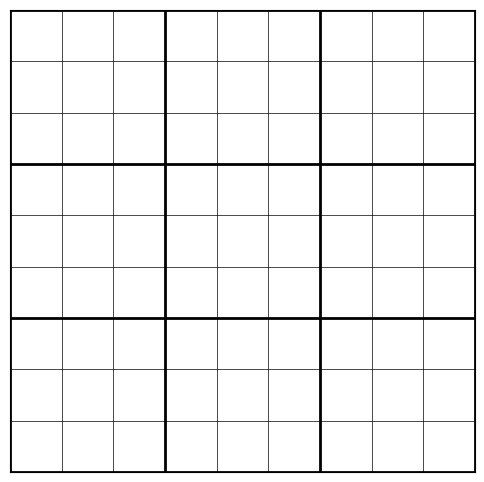

Bot plays: (0, 2, 1, 1)

Current Turn: Player O


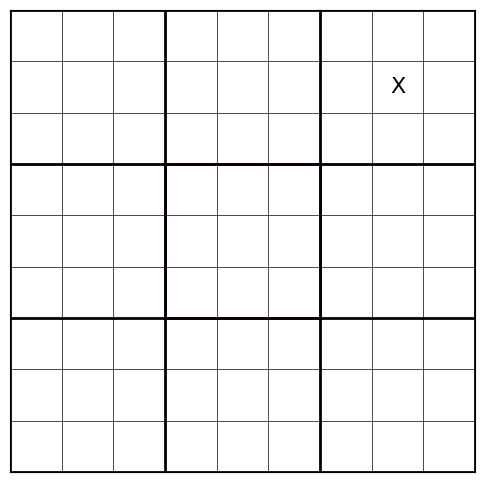

Bot plays: (1, 1, 1, 1)

Current Turn: Player X


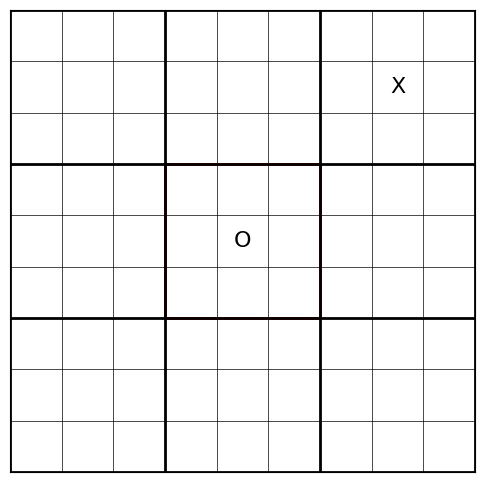

Bot plays: (1, 1, 0, 2)

Current Turn: Player O


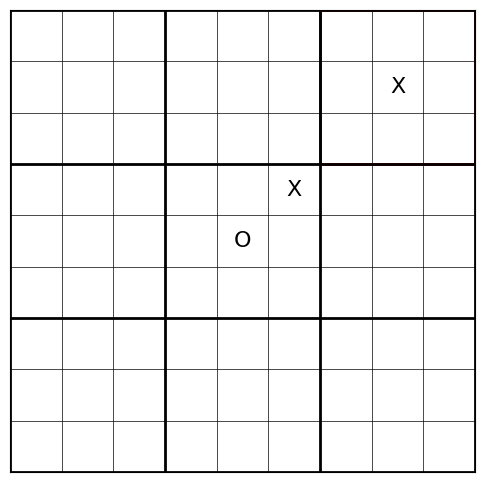

Bot plays: (0, 2, 0, 2)

Current Turn: Player X


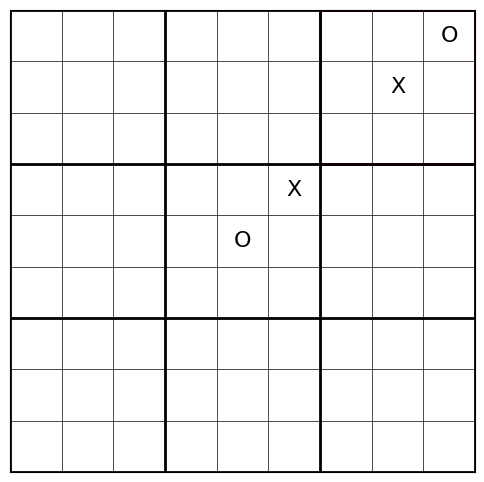

Bot plays: (0, 2, 0, 1)

Current Turn: Player O


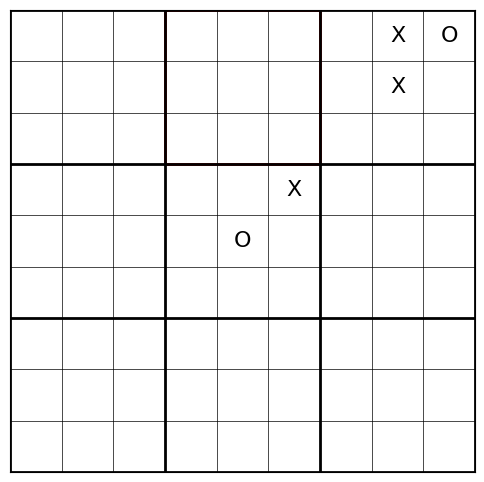

Bot plays: (0, 1, 1, 1)

Current Turn: Player X


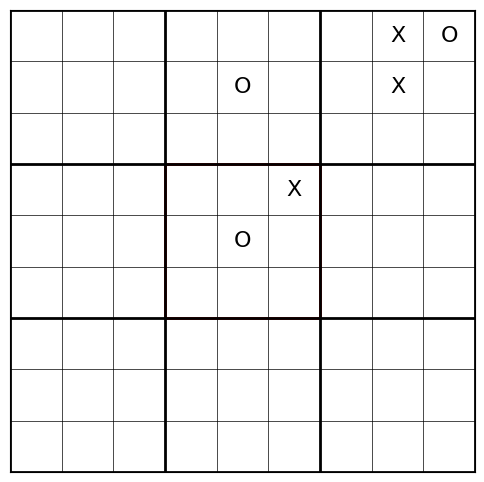

Bot plays: (1, 1, 0, 0)

Current Turn: Player O


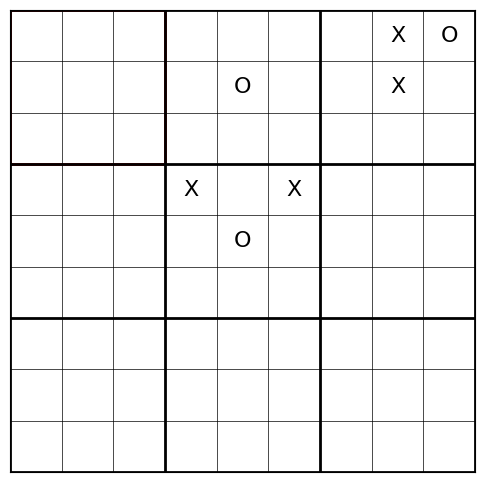

Bot plays: (0, 0, 2, 0)

Current Turn: Player X


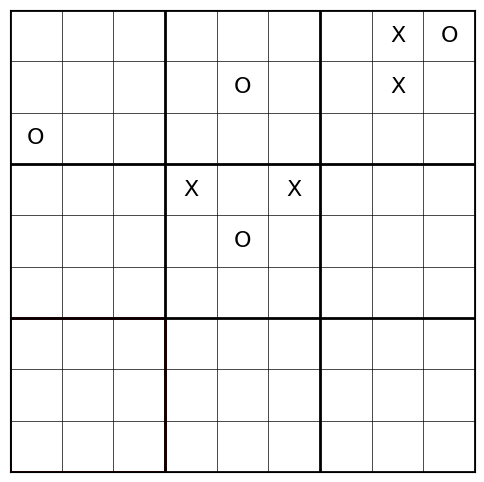

Bot plays: (2, 0, 2, 0)

Current Turn: Player O


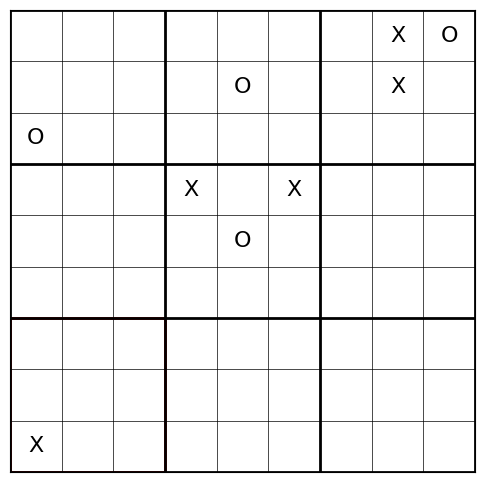

Bot plays: (2, 0, 1, 1)

Current Turn: Player X


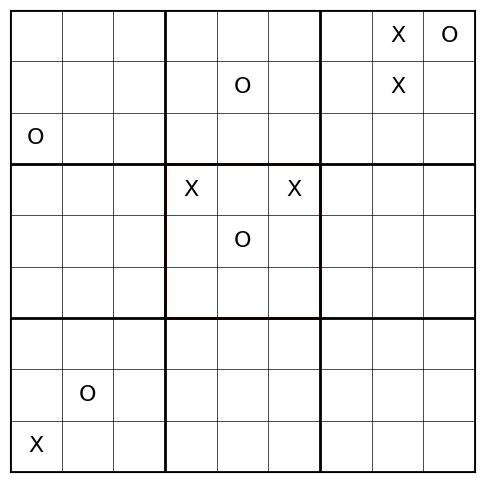

Bot plays: (1, 1, 1, 0)

Current Turn: Player O


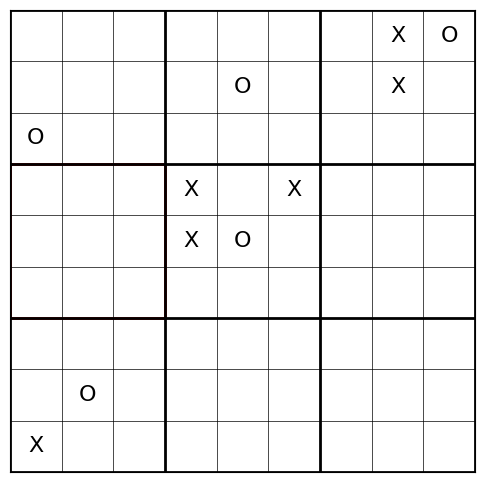

Bot plays: (1, 0, 1, 1)

Current Turn: Player X


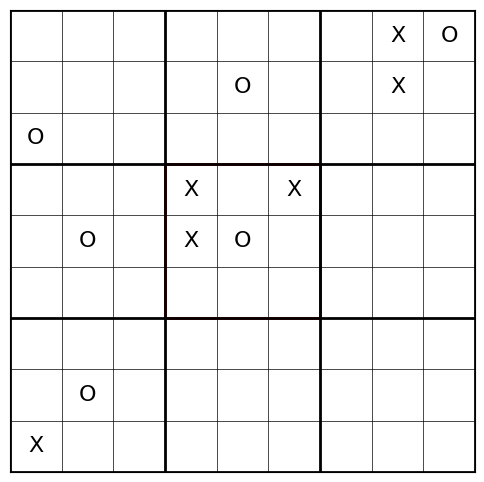

Bot plays: (1, 1, 2, 0)

Current Turn: Player O


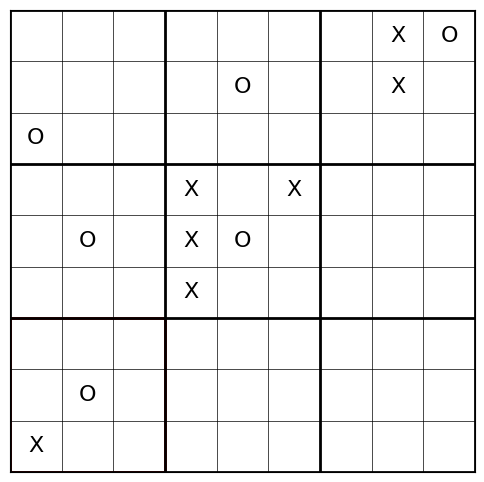

Bot plays: (2, 0, 1, 0)

Current Turn: Player X


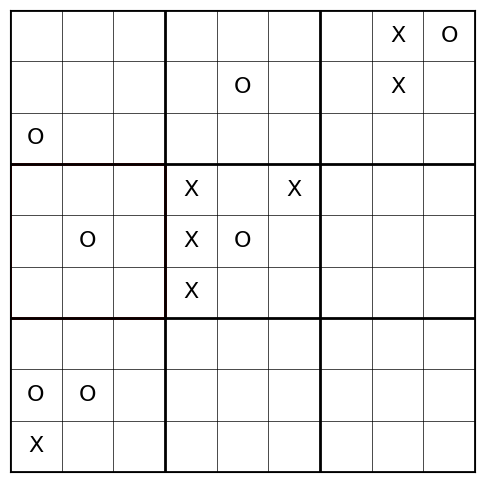

Bot plays: (1, 0, 0, 2)

Current Turn: Player O


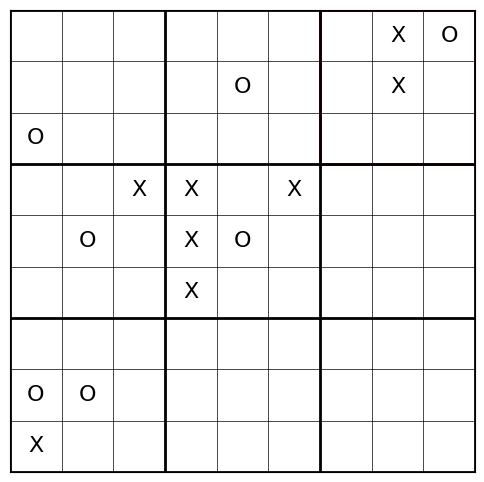

Bot plays: (0, 2, 2, 1)

Current Turn: Player X


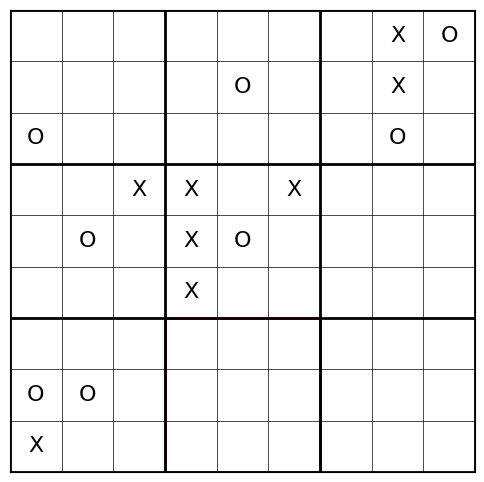

Bot plays: (2, 1, 2, 1)

Current Turn: Player O


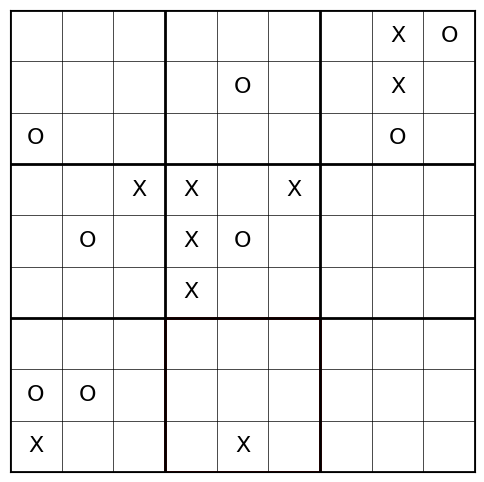

Bot plays: (2, 1, 1, 1)

Current Turn: Player X


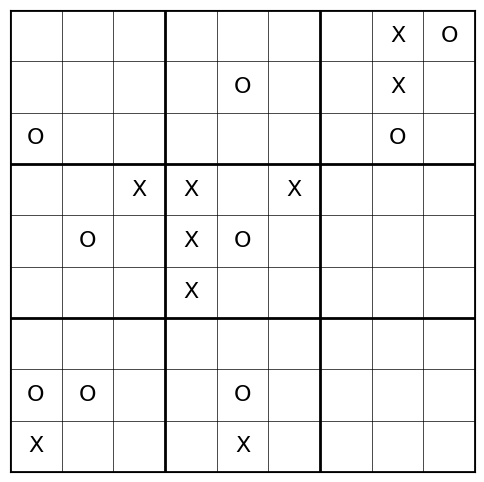

Bot plays: (1, 0, 1, 0)

Current Turn: Player O


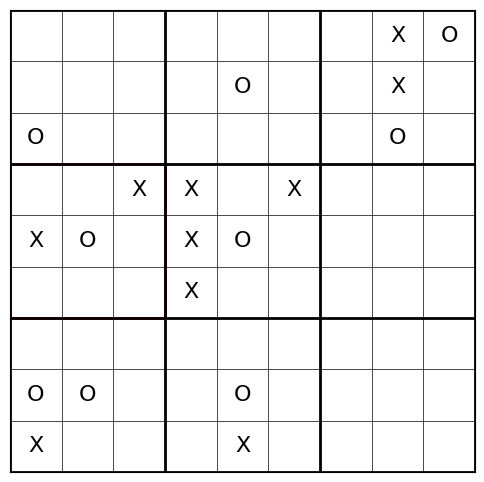

Bot plays: (1, 0, 2, 2)

Current Turn: Player X


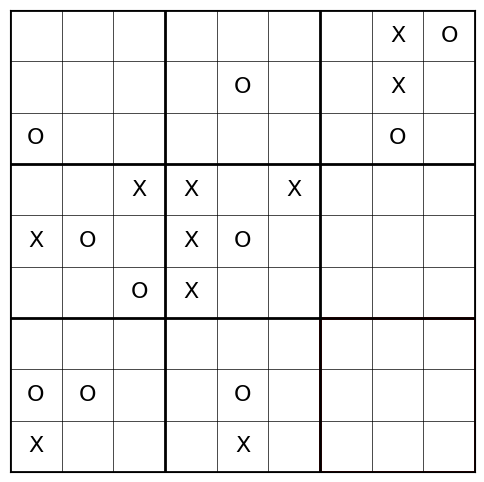

Bot plays: (2, 2, 0, 0)

Current Turn: Player O


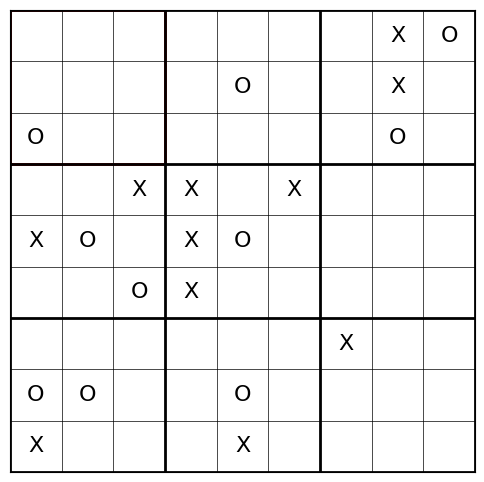

Bot plays: (0, 0, 2, 2)

Current Turn: Player X


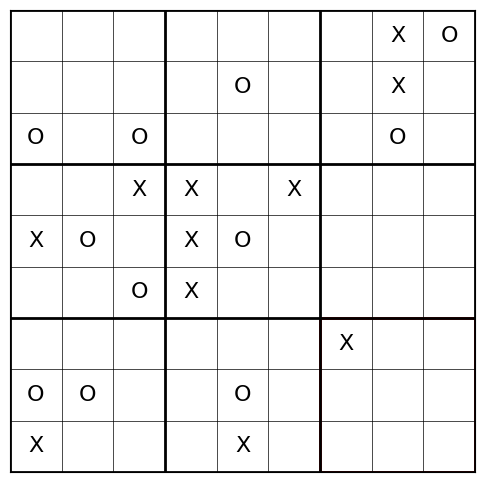

Bot plays: (2, 2, 2, 2)

Current Turn: Player O


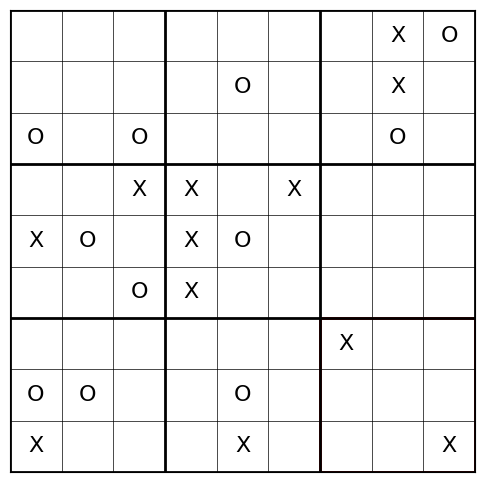

Bot plays: (2, 2, 1, 1)

Current Turn: Player X


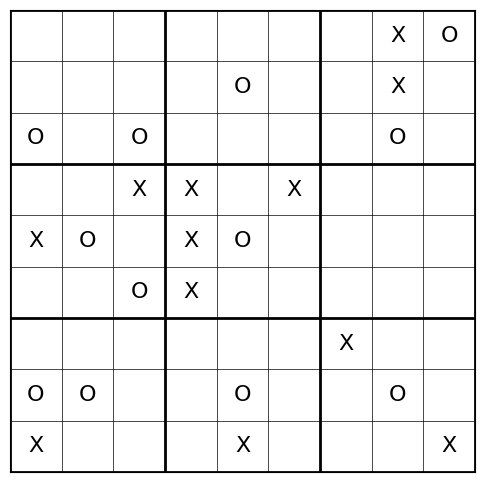

Bot plays: (2, 0, 0, 0)

Current Turn: Player O


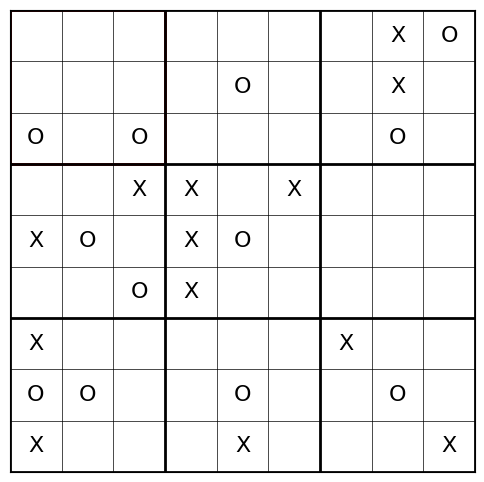

Bot plays: (0, 0, 2, 1)

Current Turn: Player X


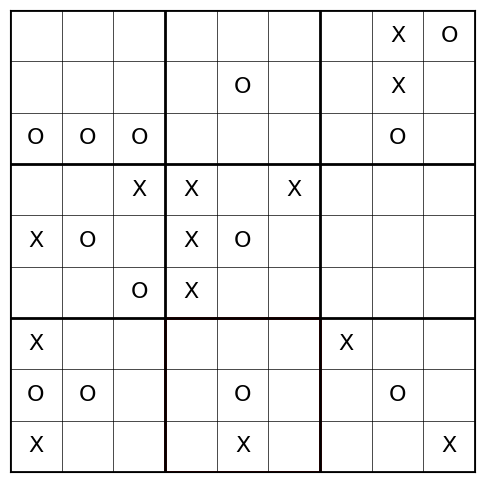

Bot plays: (2, 1, 2, 2)

Current Turn: Player O


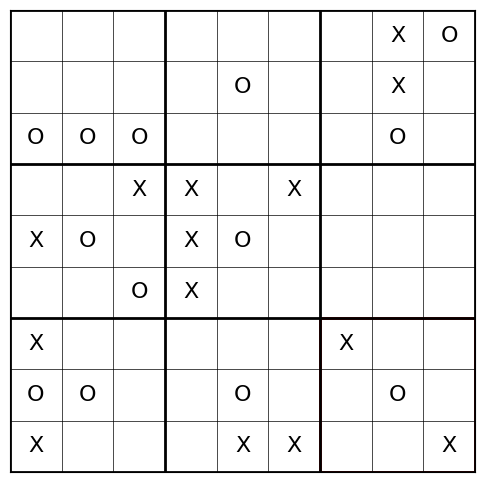

Bot plays: (2, 2, 1, 0)

Current Turn: Player X


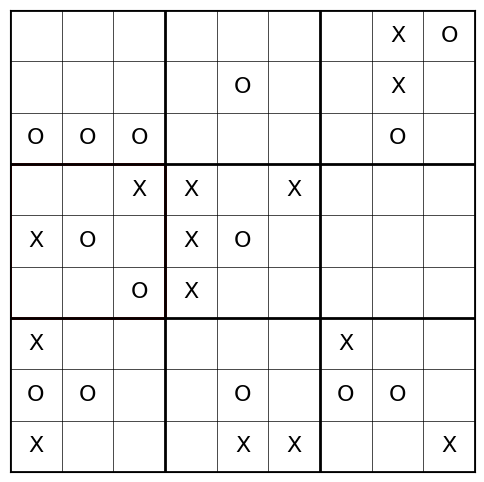

Bot plays: (1, 0, 1, 2)

Current Turn: Player O


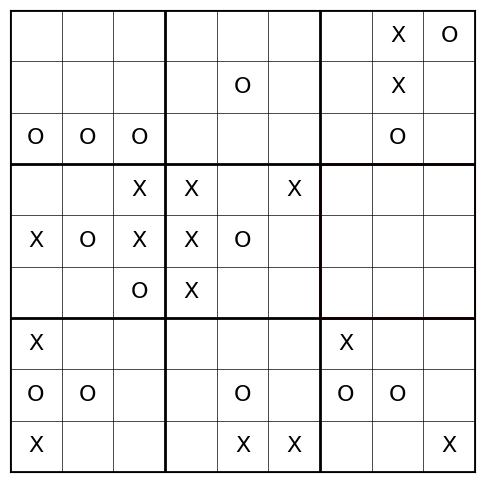

Bot plays: (1, 2, 0, 2)

Current Turn: Player X


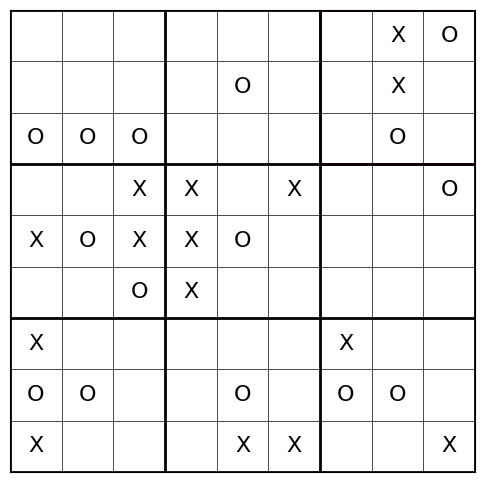

Bot plays: (0, 2, 0, 0)

Current Turn: Player O


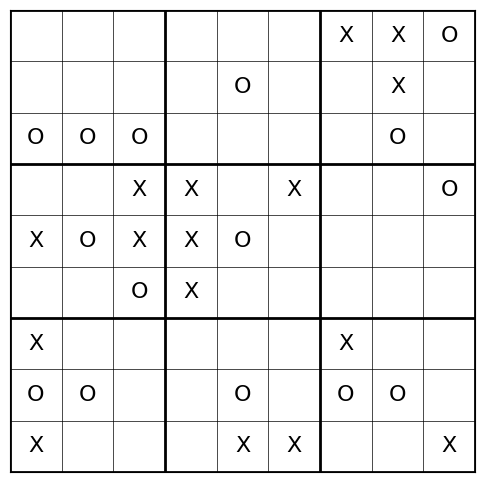

Bot plays: (1, 2, 1, 1)

Current Turn: Player X


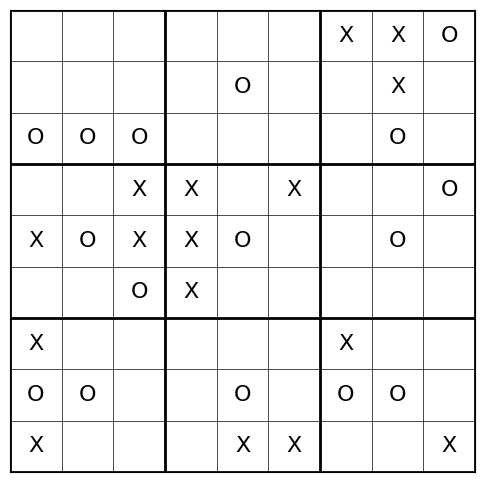

Bot plays: (2, 0, 2, 2)

Current Turn: Player O


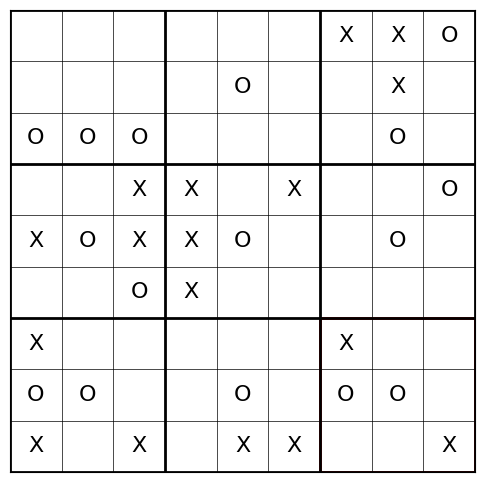

Bot plays: (2, 2, 1, 2)

Current Turn: Player X


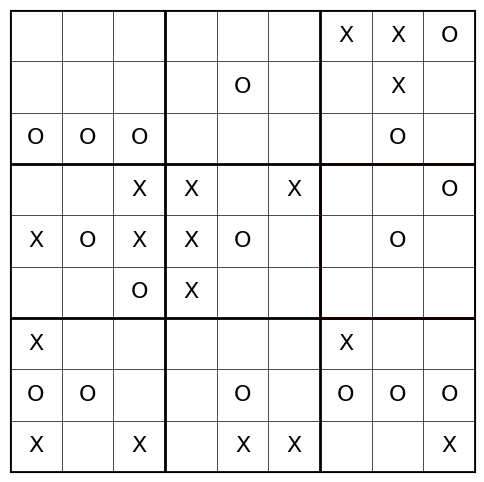

Bot plays: (1, 2, 0, 0)

Current Turn: Player O


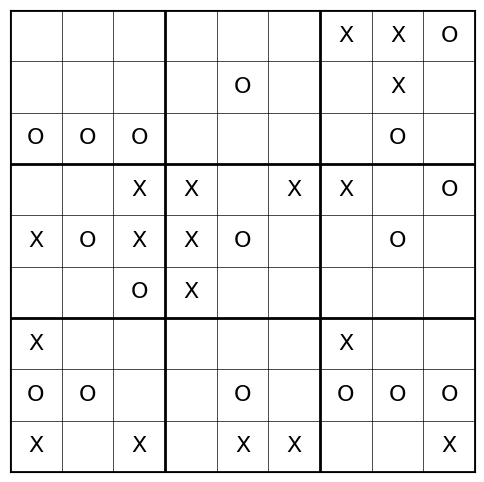

Bot plays: (0, 2, 2, 2)

Current Turn: Player X


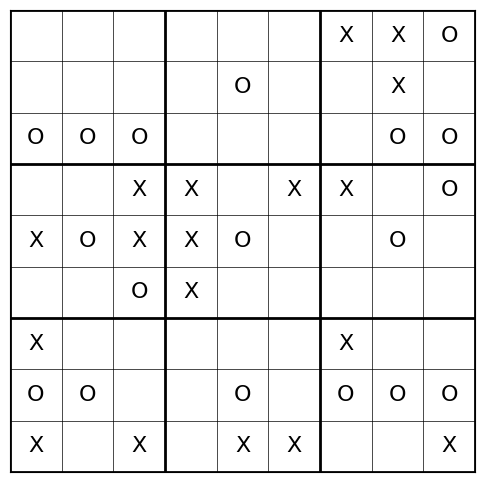

Bot plays: (0, 2, 1, 2)

Current Turn: Player O


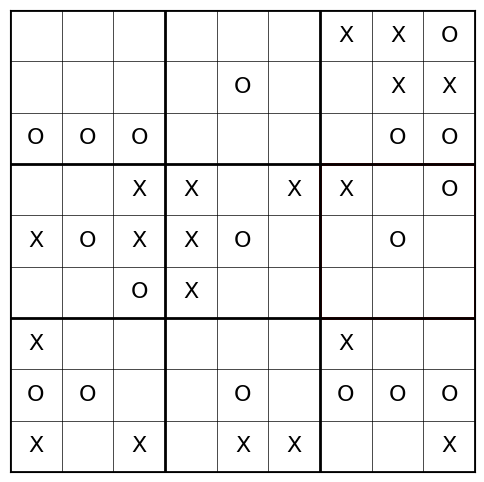

Bot plays: (1, 2, 2, 0)

Current Turn: Player X


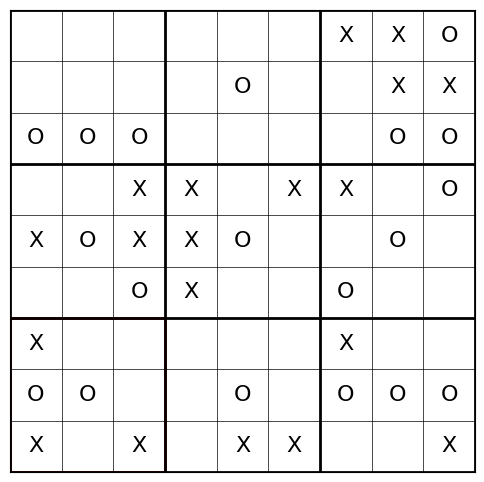

Bot plays: (2, 0, 0, 2)

Current Turn: Player O


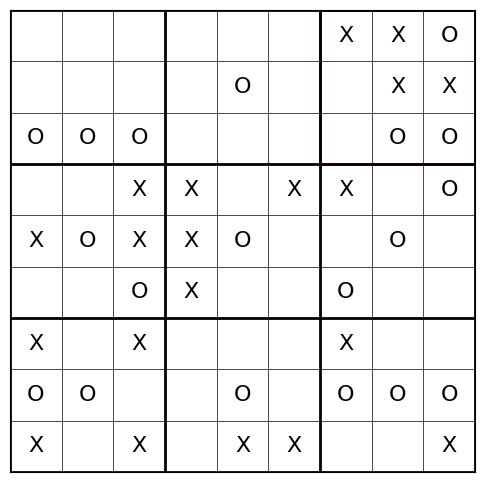

Bot plays: (0, 2, 2, 0)

Final Result:


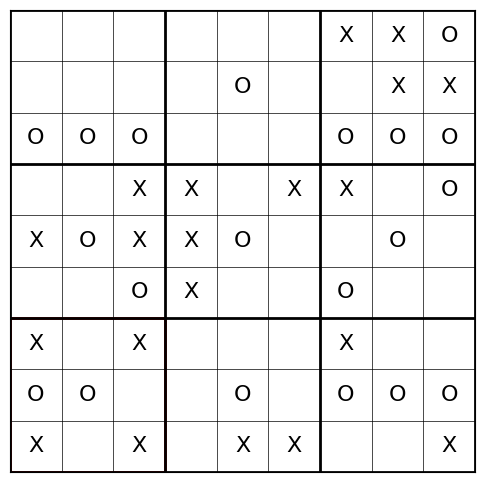

Winner: Player O


In [91]:
def random_bot(board: UltimateBoard):
    return random.choice(board.get_legal_moves())
def play_game(agent_X=None, agent_O=None):
    """
    Play a game of Ultimate Tic-Tac-Toe.

    agent_X: function that takes (UltimateBoard) and returns a move, or None for human
    agent_O: function that takes (UltimateBoard) and returns a move, or None for human
    """
    game = UltimateBoard()

    while not game.global_winner and game.get_legal_moves():
        print("\nCurrent Turn: Player {}".format("X" if game.current_player == 1 else "O"))
        ultimate_board_to_board(game)
        """
        if game.next_board:
            print("You must play in small board:", game.next_board)
        else:
            print("You may play in any active board.")
        """
        # Determine agent for this turn
        agent = agent_X if game.current_player == 1 else agent_O

        if agent is None:
            # Human move
            move = input("Enter your move (big_r big_c small_r small_c): ").split()
            try:
                move = tuple(map(int, move))
                if len(move) != 4 or not game.play_move(*move):
                    print("Try again.")
            except:
                print("Invalid input.")
        else:
            # Bot move
            move = agent(game)
            print(f"Bot plays: {move}")
            game.play_move(*move)

    print("\nFinal Result:")
    ultimate_board_to_board(game)
    if game.global_winner:
        print("Winner: Player", "X" if game.global_winner == 1 else "O")
    else:
        print("Game ended in a draw.")

play_game(agent_X=random_bot, agent_O=enhanced_mcts_bot_wrapper)
